In [14]:
import numpy as np
import time
from PySDM import Formulae
from PySDM.physics.constants import si
from PySDM.backends import CPU
from PySDM_examples.Luettmer_homogeneous_freezing.simulation import Simulation
from PySDM_examples.Luettmer_homogeneous_freezing.settings import Settings
from PySDM_examples.Luettmer_homogeneous_freezing import plot
from importlib import reload
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot


In [ ]:
"""  basic setup for homogeneous freezing of pure-liquid droplets """
"""
Ensemble for:
2. w
3. n_c
"""

n_sd = 100
number_concentration_droplets = 850 / si.cm**3
mean_radius_dry_aerosol= 15 * si.nanometer
updraft = 1 * si.meter / si.second
initial_temperature =  -25. + 273.
time_step = 1. * si.second

common = {  "n_sd": n_sd,
    "w_updraft": updraft,
    "T0":  initial_temperature,
    "dt": time_step,
    "N_dv_droplet_distribution": number_concentration_droplets,
    "r_mean_droplet_distribution": mean_radius_dry_aerosol,
    "type_droplet_distribution": "monodisperse",
    "RH_0":0.995,
    "condensation_enable": True,
    "deposition_enable": False,
            }

backends = {
   "threshold": CPU(formulae = Formulae(
        particle_shape_and_density="MixedPhaseSpheres",
        homogeneous_ice_nucleation_rate="Null",
        seed=time.time_ns(),
    )),
    "KoopMurray2016": CPU(formulae = Formulae(
        particle_shape_and_density="MixedPhaseSpheres",
        homogeneous_ice_nucleation_rate="KoopMurray2016",
        seed=time.time_ns(),
    )),
   "Koop_Correction": CPU(formulae = Formulae(
        particle_shape_and_density="MixedPhaseSpheres",
        homogeneous_ice_nucleation_rate="Koop_Correction",
        seed=time.time_ns(),
    )),
    "Koop2000": CPU(formulae = Formulae(
        particle_shape_and_density="MixedPhaseSpheres",
        homogeneous_ice_nucleation_rate="Koop2000",
        seed=time.time_ns(),
    )),
}
hom_freezing_types = backends.keys()

number_of_nsd = (10, 100, 1000)

simulations = []

for hom_freezing_type in backends.keys():
    for n_sd in number_of_nsd:
        setting_dict = {
            **common,
            "n_sd": n_sd,
            "backend": backends[hom_freezing_type],
            "hom_freezing": hom_freezing_type,
            }
        if hom_freezing_type == "threshold":
            number_of_ensemble_runs = 1
        else:
            number_of_ensemble_runs = 5
        simulation = { "settings": setting_dict,
                       "number_of_ensemble_runs": number_of_ensemble_runs,
                       "ensemble_member_outputs": [],
                       }
        simulations.append( simulation )

In [23]:
for simulation in simulations:
    for n in range(simulation["number_of_ensemble_runs"]):
        setting = Settings(**simulation["settings"])
        setting.formulae.seed += 1
        model = Simulation(setting)
        simulation["ensemble_member_outputs"].append( model.run() )

Setting up simulation with threshold
1752243231880422753
Starting simulation...
all particles frozen
Setting up simulation with threshold
1752243248254589262
Starting simulation...
all particles frozen
Setting up simulation with threshold
1752243253321461366
Starting simulation...
all particles frozen
Setting up simulation with Koop_Correction
1752243259546906337
Starting simulation...
all particles frozen
Setting up simulation with Koop_Correction
1752243281011657880
Starting simulation...
all particles frozen
Setting up simulation with Koop_Correction
1752243286214768833
Starting simulation...
all particles frozen
Setting up simulation with Koop_Correction
1752243290603646324
Starting simulation...
all particles frozen
Setting up simulation with Koop_Correction
1752243295069281313
Starting simulation...
all particles frozen
Setting up simulation with Koop_Correction
1752243299834129172
Starting simulation...
all particles frozen
Setting up simulation with Koop_Correction
175224330472

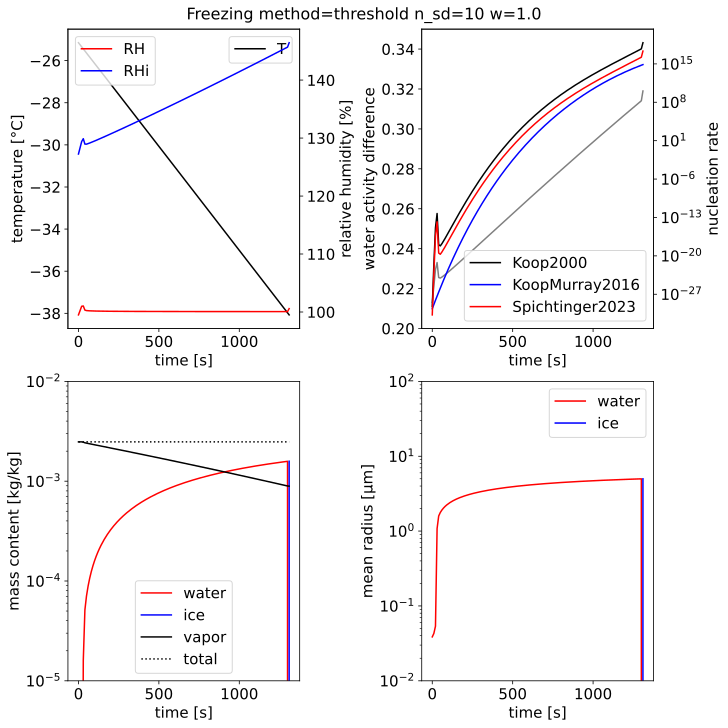

In [24]:
plot.plot_thermodynamics_and_bulk(simulations[0])

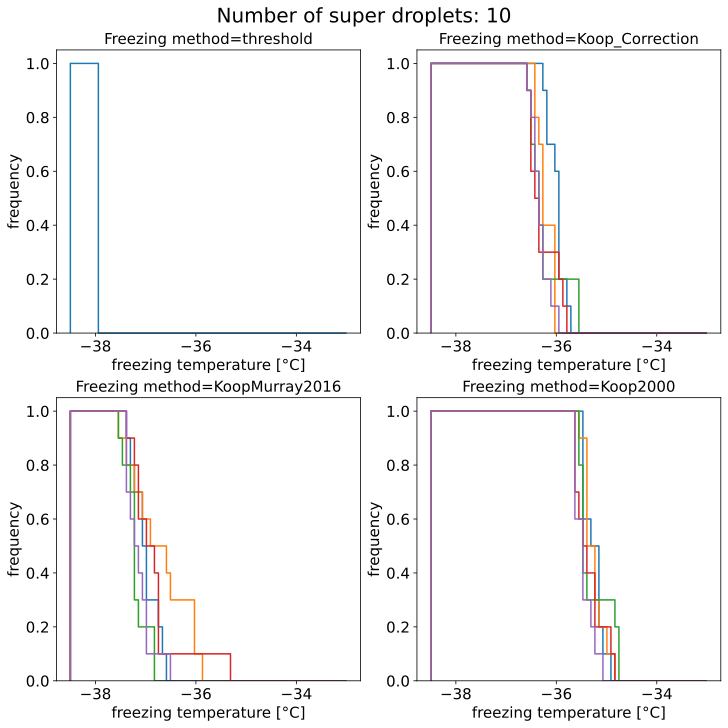

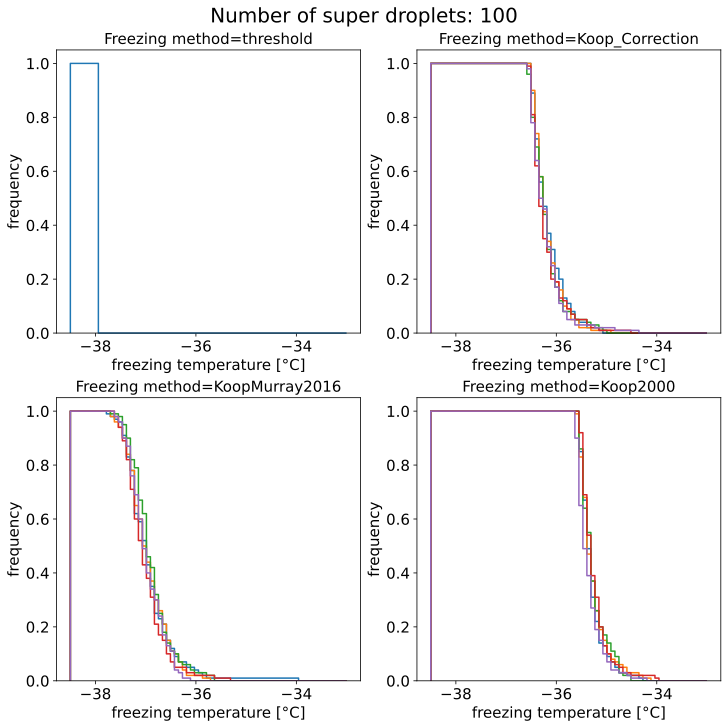

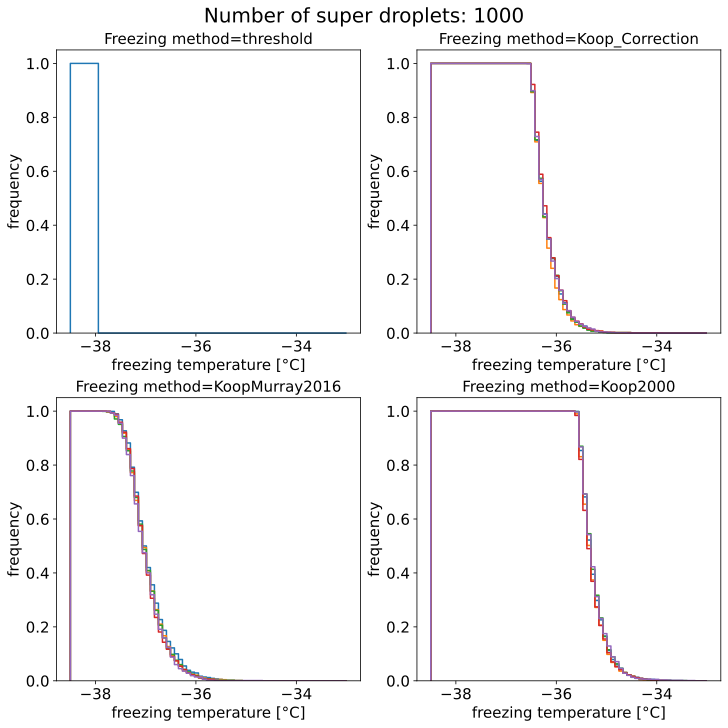

In [38]:
for n_sd in number_of_nsd:
    fig, axs = pyplot.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
    fig.suptitle("Number of super droplets: {}".format(n_sd),fontsize=20)
    axs = axs.ravel()
    i = 0
    for simulation in simulations:
        if simulation["settings"]["n_sd"] == n_sd and simulation["settings"]["w_updraft"] == 1:
            axs[i] = plot.plot_freezing_temperatures(axs[i], simulation)
            i += 1
    show_plot()
